Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
from scipy.optimize import least_squares, curve_fit, minimize
from scipy.interpolate import interp1d
import numpy as np
%matplotlib widget


Plot Raw Data

In [ ]:

def plot(csv_files):

    # Find all CSV files that start with "TEK"
    # csv_files = glob.glob("TEK*.csv")

    plt.figure(figsize=(10, 6))

    # Loop through each CSV file and plot its data
    for file in csv_files:
        # Read CSV file, skipping the first 16 rows
        data = pd.read_csv(file, skiprows=16)
        
        # Assuming the first column is x and the second is y
        x = data.iloc[:, 0]
        y = data.iloc[:, 1]
        
        # Plot the data
        plt.plot(x, y, label=file)

    # Configure the plot
    plt.xlabel("Time (s)")
    plt.ylabel("Signal (V)")
    plt.title("Plot of " + str(csv_files))
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()


Data Analysis

Optimizing the Fit Window (Work in Progress)

In [ ]:
def optimize_ls(file1,file2, meth=None):

    # Find all CSV files that start with "TEK"
    # csv_files = glob.glob("TEK*.csv")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    data1 = pd.read_csv(file1, skiprows=16)
    
    # Assuming the first column is x and the second is y
    x1 = data1.iloc[:, 0]
    y1 = data1.iloc[:, 1]
    
    data2 = pd.read_csv(file2, skiprows=16)
    
    # Assuming the first column is x and the second is y
    x2 = data2.iloc[:, 0]
    y2 = data2.iloc[:, 1]

    # Define residuals function fitting x2 to x1
    def residuals(p, b):

        d1 = np.array([x1, y1]).transpose()
        d2 = np.array([x2, y2]).transpose()
        d1 = np.array([d for d in d1 if d[0] < b[1] and d[0] > b[0]]).transpose()
        d2 = np.array([d for d in d2 if d[0] < b[1] and d[0] > b[0]]).transpose()  

        x1_func = interp1d(x1, y1, fill_value=np.nan, kind="linear")
        cut_x2_func = interp1d(d2[0], d2[1], fill_value=np.nan, kind="linear")

        # params p: a, b, t
        return [x1_func(d2[0,i]-p[2]) - (cut_x2_func(d2[0,i])*p[0] + p[1]) for i in range(len(d2[0]))]

    def fit(b):
        #Make cuts to data around signal region
        # Use curve_fit to determine best a, b, and c
        result = least_squares(lambda x: residuals(x,b), x0=[0.5, 0, 3e-7], bounds=([0,-0.6,0],[np.inf,0.6,1e-6]))  # Initial guess: a=1, b=0, c=0
        a,b,t = result.x

        #Return value of the cost function
        return result
    
    def fit_func(b):
        result = fit(b)
        hess_inv = np.linalg.inv(np.dot(result.jac.T, result.jac))
        d2 = np.array([x2, y2]).transpose()
        d2 = np.array([d for d in d2 if d[0] < b[1] and d[0] > b[0]]).transpose()
        mse = (np.array(residuals(result.x, b))**2).sum()/(len(d2[0])-3)
        sigma = np.sqrt(np.diag(hess_inv * mse))
        u_t = sigma[2]
        return result.cost

    minimize_result = minimize(fit_func, x0=[-0.85e-5, -0.2e-5], bounds = ((-0.92e-5, -0.7e-5), (-0.66e-5,0.2e-5)),options={'disp':True}, method=meth)
    low, high = minimize_result.x


    # Plot and Fit optimized fit

    #Make cuts to data around signal region
    d1 = np.array([x1, y1]).transpose()
    d2 = np.array([x2, y2]).transpose()
    d1 = np.array([d for d in d1 if d[0] < high and d[0] > low]).transpose()
    d2 = np.array([d for d in d2 if d[0] < high and d[0] > low]).transpose()

    #Get fit parametrs again
    best_result = fit([low, high])
    a,b,t = best_result.x

    print(best_result.x)

    ax1.plot(x1, y1, label="Short", color='blue')
    ax1.plot(x2,y2, label="Long",  color='orange')

    # Apply transformation using best-fit parameters
    x3 = d2[0]-t
    y3 = d2[1]*a + b

    ax1.plot(x3, y3, label="Fit: $\Delta$t = " + str(-round(t*(10**9),2)) + "ns", ls='-', color='red', lw=1)
        

    # Configure the plot
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Normalized Signal")
    ax1.set_title("Short and Long Path Laser Pulse Signals")
    ax1.legend()
    ax1.grid()
    ax1.set_xlim(-1e-5,0.2e-5)

    x1_func = interp1d(x1, y1, fill_value=np.nan, kind="linear")
    #cut_x1_func = interp1d(d1[0], d1[1], fill_value=np.nan, kind="linear")
    #x2_func = interp1d(x2, y2, fill_value=np.nan, kind="linear")
    cut_x2_func = interp1d(d2[0], d2[1], fill_value=np.nan, kind="linear")


    ax2.scatter(d2[0], residuals(best_result.x, (low,high)),s=0.1)
    # Configure the plot
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Residual (V)")
    ax2.set_title("Fit Residuals")
    ax2.grid()
    ax2.set_xlim(low, high)

    plt.tight_layout()
    plt.show()

    res = residuals(best_result.x, (low,high))

    hess_inv = np.linalg.inv(np.dot(best_result.jac.T, best_result.jac))
    mse = (np.array(res)**2).sum()/(len(d2[0])-3)
    sigma = np.sqrt(np.diag(hess_inv * mse))
    u_t = sigma[2]

    print("t " + str(t))
    print("u_t " + str(u_t))
    print("mse " + str(mse))


    d = 102.572
    u_d = 0.204
    c = d/t
    u_c = c * np.sqrt((u_d/d)**2 + (u_t/t)**2)

    print("c = " + str(c))
    print("u_c = " + str(u_c))
    print("cost function " + str(best_result.cost))
    print("low " + str(low))
    print("high " + str(high))

Least Squares Fit

In [ ]:

def plot_ls(file1,file2, low_cut, high_cut):

    # Find all CSV files that start with "TEK"
    # csv_files = glob.glob("TEK*.csv")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    data1 = pd.read_csv(file1, skiprows=16)
    
    # Assuming the first column is x and the second is y
    x1 = data1.iloc[:, 0]
    y1 = data1.iloc[:, 1]
    
    data2 = pd.read_csv(file2, skiprows=16)
    
    # Assuming the first column is x and the second is y
    x2 = data2.iloc[:, 0]
    y2 = data2.iloc[:, 1]

    d1 = np.array([x1, y1]).transpose()
    d2 = np.array([x2, y2]).transpose()
    d1 = np.array([d for d in d1 if d[0] < high_cut and d[0] > low_cut]).transpose()
    d2 = np.array([d for d in d2 if d[0] < high_cut and d[0] > low_cut]).transpose()   
    
    x1_func = interp1d(x1, y1, fill_value=np.nan, kind="linear")
    #cut_x1_func = interp1d(d1[0], d1[1], fill_value=np.nan, kind="linear")
    x2_func = interp1d(x2, y2, fill_value=np.nan, kind="linear")
    cut_x2_func = interp1d(d2[0], d2[1], fill_value=np.nan, kind="linear")

    # Define residuals function fitting x2 to x1
    def residuals(p):
        # params p: a, b, t
        return [x1_func(d2[0,i]) - (x2_func(d2[0,i]+p[2])*p[0] + p[1]) for i in range(len(d2[0]))]
    
    
    # Use curve_fit to determine best a, b, and c
    result = least_squares(residuals, x0=[0.5, 0, 3e-7], bounds=([0,-0.6,0],[np.inf,0.6,1e-6]))  # Initial guess: a=1, b=0, c=0
    a,b,t = result.x

    print(result.x)

    #Plot Normalization to Short Path
    miny1 = min(y1)
    maxy1=max(y1) - miny1

    miny2 = min(y2)
    maxy2=max(y2)-miny2

    ax1.plot(x1, y1, label="Short Path", color='blue')
    ax1.plot(x2, y2, label="Long Path",  color='orange')

    # Apply transformation using best-fit parameters
    x3 = d2[0]-t
    y3 = d2[1]*a + b
    miny3 = min(y3)
    maxy3=max(y3)-miny3

    ax1.plot(x3, y3, label="Fit: $\Delta$t = " + str(-round(t*(10**9),2)) + "ns", ls='-', color='red', lw=1)
        

    # Configure the plot
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Signal (V)")
    ax1.set_title("Interferometer Laser Pulse Signals")
    ax1.legend()
    ax1.grid()
    ax1.set_xlim(-1e-5,1e-5)

    ax2.scatter(d2[0], [-r for r in residuals(result.x)],s=0.1, color='red')
    # Configure the plot
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Residual (V)")
    ax2.set_title("Fit Residuals")
    ax2.grid()
    ax2.set_xlim(low_cut, high_cut)

    plt.tight_layout()
    plt.show()

    dof = len(d2[0]) -3

    hess_inv = np.linalg.inv(np.dot(result.jac.T, result.jac))
    rss = (np.array(residuals(result.x))**2).sum()
    mse = rss/dof
    sigma2 = np.diag(hess_inv * mse)
    u_t = np.sqrt(sigma2[2])

    chi2 = rss/(0.005**2+(0.0001*a)**2)

    print("t " + str(t))
    print("u_t " + str(u_t))
    print("mse " + str(mse))
    print("chi2 " + str(chi2))

 


    d = 102.572
    #u_d = 0.204
    u_d=0.51
    c = d/t
    u_c = c * np.sqrt((u_d/d)**2 + (u_t/t)**2)

    print("c = " + str(c))
    print("u_c = " + str(u_c))
    print("cost function " + str(result.cost))
    print("low " + str(low_cut))
    print("high " + str(high_cut))




Plot Averages

In [4]:
def plot_avg(range1,range2, low_cut, high_cut, linewidth):

    # Find all CSV files that start with "TEK"
    def csv_files(i):
        return glob.glob("TEK*0" + str(i) + ".CSV")
    
    short_files = [csv_files(i)[0] for i in range1]
    long_files = [csv_files(i)[0] for i in range2]


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    x1 = np.mean( np.array( [np.array(pd.read_csv(f, skiprows=16).iloc[:,0]) for f in short_files]), axis=0)
    y1 = np.mean( np.array( [np.array(pd.read_csv(f, skiprows=16).iloc[:,1]) for f in short_files]), axis=0)
    sd1 = np.std( np.array( [np.array(pd.read_csv(f, skiprows=16).iloc[:,1]) for f in short_files]), axis=0)

    x2 = np.mean( np.array( [np.array(pd.read_csv(f, skiprows=16).iloc[:,0]) for f in long_files]), axis=0 )
    y2 = np.mean( np.array( [np.array(pd.read_csv(f, skiprows=16).iloc[:,1]) for f in long_files]), axis=0 )
    sd2 = np.std( np.array( [np.array(pd.read_csv(f, skiprows=16).iloc[:,1]) for f in long_files]), axis=0 )


    d1 = np.array([x1, y1, sd1]).transpose()
    d2 = np.array([x2, y2, sd2]).transpose()
    d1 = np.array([d for d in d1 if d[0] < high_cut and d[0] > low_cut]).transpose()
    d2 = np.array([d for d in d2 if d[0] < high_cut and d[0] > low_cut]).transpose()

    
    x1_func = interp1d(x1, y1, fill_value=np.inf, kind="linear")
    #cut_x1_func = interp1d(d1[0], d1[1], fill_value=np.nan, kind="linear")
    sd1_func = interp1d(x1, sd1, fill_value=np.inf, kind="linear")
    x2_func = interp1d(x2, y2, fill_value=np.inf, kind="linear")
    sd2_func = interp1d(x2, sd2, fill_value=np.inf, kind="linear")
    cut_x2_func = interp1d(d2[0], d2[1], fill_value=np.inf, kind="linear")


    def fit_func(p, i):
        a,b,t = p
        return a * x2_func(d2[0, i] + t) + b
    
    def fit_sd_func(p, i):
        a,b,t = p
        return a * sd2_func(d2[0, i] + t)
    
    # Define residuals function fitting x2 to x1
    def residuals(p):
        # params p: a, b, t
        return [ (fit_func(p, i) - d1[1,i]) / np.sqrt(sd1[i]**2 + fit_sd_func(p,i)**2)  for i in range(len(d2[0]))]
    
    # Define residuals function fitting x2 to x1
    def pure_residuals(p):
        # params p: a, b, t
        return [ (fit_func(p, i) - d1[1,i])   for i in range(len(d2[0]))]
    

    
    # Use curve_fit to determine best a, b, and c
    result = least_squares(residuals, x0=[0.5, 0, 3e-7], bounds=([0,-0.6,0],[np.inf,0.6,1e-6]))  # Initial guess: a=1, b=0, c=0
    a,b,t = result.x

    #result = curve_fit(fit_func, d1[0], d1[1], p0=[1, 0, 3e-7], bounds=([0,-0.6,0],[np.inf,0.6,1e-6]), sigma=sd1)

    print(result.x)

    #Plot Normalization to Short Path
    miny1 = min(y1)
    maxy1=max(y1) - miny1

    miny2 = min(y2)
    maxy2=max(y2)-miny2

    ax1.plot(x1, y1, lw=linewidth*2, label="Short Path", color='blue')
    ax1.errorbar(x1,y1, yerr=sd1, fmt = 'none', color='blue', errorevery=100, elinewidth=linewidth*2)
    # ax3.plot(x1, sd1)
    # ax3.plot(x2,sd2)


    # Apply transformation using best-fit parameters
    x3 = d2[0]-t
    y3 = d2[1]*a + b
    sd3= d2[2]*a
    miny3 = min(y3)
    maxy3=max(y3)-miny3

    ax1.plot(x2, y2, label="Long Path",  color='orange', lw=linewidth)
    ax1.errorbar(x2,y2,yerr=sd2, fmt= 'none', color='orange', errorevery=100, elinewidth=linewidth)

    ax1.plot(x3, y3,label="Fit: $\Delta$t = " + str(-round(t*(10**9),2)) + "ns", ls='-', color='red', lw=linewidth)
    ax1.errorbar(x3,y3,yerr=sd3, fmt='none',color='red', errorevery=100, elinewidth=linewidth)



    # Configure the plot
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Signal (V)")
    ax1.set_title("Laser Pulse Signals")
    ax1.legend()
    ax1.grid()
    ax1.set_xlim(-1e-5,1e-5)

    ax2.scatter(d2[0], [-r for r in pure_residuals(result.x)],s=0.1, color='red')
    # Configure the plot
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Residual (V)")
    ax2.set_title("Fit Residuals")
    ax2.grid()
    ax2.set_xlim(low_cut, high_cut)

    plt.tight_layout()
    plt.show()

    dof = len(d2[0]) -3

    hess_inv = np.linalg.inv(np.dot(result.jac.T, result.jac))
    chi2 = (np.array(residuals(result.x))**2).sum()
    rss = (np.array(pure_residuals(result.x))**2).sum()
    mse = rss/dof
    sigma2 = np.diag(hess_inv * chi2/dof)
    u_t = np.sqrt(sigma2[2])

    print("t " + str(t))
    print("u_t " + str(u_t))
    print("mse " + str(mse))
    print("chi2 " + str(chi2))
    print("dof " + str(dof))
    print("chi2/dof " + str(chi2/dof))

 


    d = 102.47
    #u_d = 0.204
    u_d=1.02
    c = d/t
    u_c = c * np.sqrt((u_d/d)**2 + (u_t/t)**2)

    print("c = " + str(c))
    print("u_c = " + str(u_c))
    print("cost function " + str(result.cost))
    print("low " + str(low_cut))
    print("high " + str(high_cut))




[ 1.00836986e+00 -8.12924655e-03  3.39753195e-07]


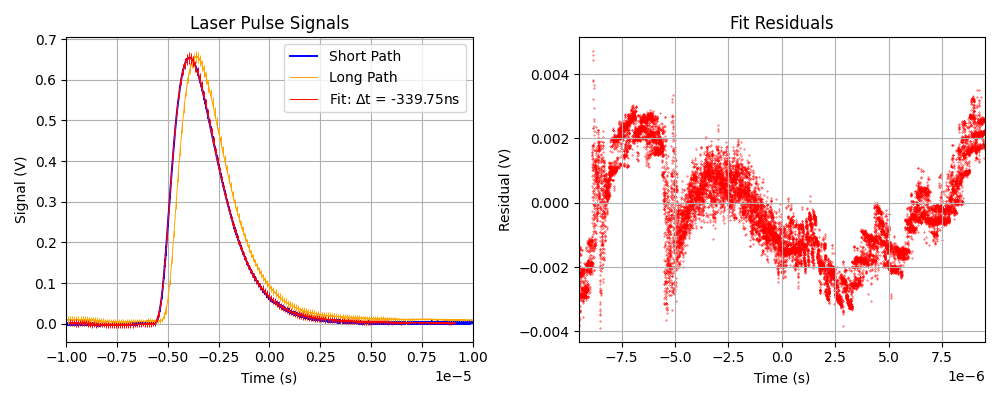

t 3.397531946186595e-07
u_t 9.58444626369419e-11
mse 2.4089738063901288e-06
chi2 720.9836348838371
dof 18996
chi2/dof 0.03795449751967978
c = 301601284.76499766
u_c = 3003384.644137153
cost function 360.4918174419186
low -9.5e-06
high 9.5e-06


In [5]:
plot_avg((10,19), (20,29), -9.5e-6, 9.5e-6, 0.7)

Orthogonal Distance Regression

In [ ]:
from scipy.odr import *

def plot_odr(file1,file2, low_cut, high_cut, ptol, stol):

    # Find all CSV files that start with "TEK"
    # csv_files = glob.glob("TEK*.csv")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))

    data1 = pd.read_csv(file1, skiprows=16)
    
    # Assuming the first column is x and the second is y
    x1 = data1.iloc[:, 0]
    y1 = data1.iloc[:, 1]
    
    data2 = pd.read_csv(file2, skiprows=16)
    
    # Assuming the first column is x and the second is y
    x2 = data2.iloc[:, 0]
    y2 = data2.iloc[:, 1]

    d1 = np.array([x1, y1]).transpose()
    d2 = np.array([x2, y2]).transpose()
    d1 = np.array([d for d in d1 if d[0] < high_cut and d[0] > low_cut]).transpose()
    d2 = np.array([d for d in d2 if d[0] < high_cut and d[0] > low_cut]).transpose()   
    
    x1_func = interp1d(x1, y1, fill_value=np.inf, kind="linear", bounds_error=False)
    cut_x1_func = interp1d(d1[0], d1[1], fill_value=np.inf, kind="linear", bounds_error=False)
    x2_func = interp1d(x2, y2, fill_value=np.inf, kind="linear", bounds_error=False)
    cut_x2_func = interp1d(d2[0], d2[1], fill_value=np.inf, kind="linear", bounds_error=False)

    # Define residuals function fitting x2 to x1

    #Definite fitted long path function
    def fit_function(B,x):
        return B[0]*x2_func(x + B[2]) + B[1]
    
    #Create model
    fit_model = Model(fit_function)

    #Create data instance
    sx = 5e-10
    sy = 5e-9
    #fit_data = Data(d1[0], d1[1], wd=1./np.power(sx,2), we=1./np.power(sy,2))
    fit_data = Data(d1[0], d1[1])

    
    #Instantiate regression
    fit_odr = ODR(fit_data, fit_model, beta0=[2, 0, 3e-7], maxit=100000,partol=ptol, sstol=stol)
    fit_odr.set_iprint(final=1)

    #Run the fit
    fit_output = fit_odr.run()
    fit_output.pprint()

    # def residuals(p):
    #     # params p: a, b, t
    #     return [x1_func(d2[0,i]-p[2]) - (cut_x2_func(d2[0,i])*p[0] + p[1]) for i in range(len(d2[0]))]
    
    # Use curve_fit to determine best a, b, and c
    #result = least_squares(residuals, x0=[0.5, 0, 3e-7], bounds=([0,-0.6,0],[np.inf,0.6,1e-6]))  # Initial guess: a=1, b=0, c=0
    a,b,t = fit_output.beta

    print(fit_output.beta)

    ax1.plot(x1, y1, label="Short Path", color='blue')
    ax1.plot(x2, y2, label="Long Path",  color='orange')

    # Apply transformation using best-fit parameters
    x3 = d2[0]-t
    y3 = a*d2[1] + b

    ax1.plot(x3, y3, label="Fit: $\Delta$t = " + str(round(t*(10**9),2)) + "ns", ls='-', color='red', lw=1)

    dof = len(d2[0]) -3
        

    # Configure the plot
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Signal (V)")
    ax1.set_title("Interferometer Laser Pulse Signals")
    ax1.legend()
    ax1.grid()
    ax1.set_xlim(-1e-5,-0.2e-5)

    #orthonormal_err = np.sqrt((fit_output.delta/)**2 + fit_output.eps**2) * np.sign(fit_output.eps)

    ax2.scatter(d2[0], fit_output.eps,s=0.1, color='red')
    # Configure the plot
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Residual (V)")
    ax2.set_title("Vertical Residuals")
    ax2.grid()
    ax2.set_xlim(low_cut, high_cut)

    ax3.scatter(d2[0], fit_output.delta,s=0.1, color='red')
    # Configure the plot
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Residual (s)")
    ax3.set_title("Horizontal Residuals")
    ax3.grid()
    ax3.set_xlim(low_cut, high_cut)

    plt.tight_layout()
    plt.show()

    # hess_inv = np.linalg.inv(np.dot(result.jac.T, result.jac))
    # mse = (np.array(residuals(result.x))**2).sum()/(len(d2[0])-3)
    # sigma = np.sqrt(np.diag(hess_inv * mse))
    # u_t = sigma[2]

    u_t = fit_output.sd_beta[2]
    mse = fit_output.sum_square/dof

    print("t " + str(t))
    print("u_t " + str(u_t))
    print("mse " + str(mse))

    plus_err = np.array([r for r in fit_output.delta if r > 0])
    min_err = np.array([r for r in fit_output.delta if r < 0])



    d = 102.572
    u_d = 0.204
    c = d/t
    u_c_stat = (u_d/d)*c
    u_c_fit = (u_t/t) * c
    b_t = np.mean(fit_output.delta)
    b_c = (b_t/t) * c

    # plus_err = np.array([r for r in fit_output.delta if r > 0])
    # minus_err = np.array([r for r in fit_output.delta if r < 0])


  
    b_t = np.mean(fit_output.delta)
    e_t = np.std(fit_output.delta)
    e_c = c * (e_t/t)

    u_t_sys = np.sqrt(fit_output.sum_square_delta/dof)
    u_c_sys = c * u_t_sys/t


    ep_t = (e_t + b_t)
    em_t = (b_t - e_t)

    ep_c = c * (ep_t/t)
    em_c = c *  (em_t/t)


    print("c = " + str(c))
    print("u_c (stat) = " + str(u_c_stat))
    print("u_c (fit) = " + str(u_c_fit))
    print("u_c (sys) = " + str(u_c_sys))
    print("low " + str(low_cut))
    print("high " + str(high_cut))

    print("bias_t " + str(b_t))
    print("std_err_t " + str(e_t))
    print("bias_c " + str(b_c))
    print("std_err_c " + str(e_c))

In [ ]:
plot_odr("short.CSV", "long.CSV", -0.85e-5, -0.2e-5, 1e-10, 1e-10)

In [ ]:
plot_odr("short_zoom.CSV", "long_zoom.CSV", -0.8e-5, -0.5e-5, 1e-9, 1e-9)

Regression with Horizontal Scale

In [ ]:
from scipy.odr import *

def plot_odr_disp(file1,file2, low_cut, high_cut):

    # Find all CSV files that start with "TEK"
    # csv_files = glob.glob("TEK*.csv")

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))

    data1 = pd.read_csv(file1, skiprows=16)
    
    # Assuming the first column is x and the second is y
    x1 = data1.iloc[:, 0]
    y1 = data1.iloc[:, 1]
    
    data2 = pd.read_csv(file2, skiprows=16)
    
    # Assuming the first column is x and the second is y
    x2 = data2.iloc[:, 0]
    y2 = data2.iloc[:, 1]

    d1 = np.array([x1, y1]).transpose()
    d2 = np.array([x2, y2]).transpose()
    d1 = np.array([d for d in d1 if d[0] < high_cut and d[0] > low_cut]).transpose()
    d2 = np.array([d for d in d2 if d[0] < high_cut and d[0] > low_cut]).transpose()   
    
    x1_func = interp1d(x1, y1, fill_value=np.inf, kind="linear", bounds_error=False)
    cut_x1_func = interp1d(d1[0], d1[1], fill_value=np.inf, kind="linear", bounds_error=False)
    x2_func = interp1d(x2, y2, fill_value=np.inf, kind="linear", bounds_error=False)
    cut_x2_func = interp1d(d2[0], d2[1], fill_value=np.inf, kind="linear", bounds_error=False)

    # Define residuals function fitting x2 to x1

    #Definite fitted long path function
    def fit_function(B,x):
        return B[0]*x2_func(B[3]*(x + B[2])) + B[1]
    
    #Create model
    fit_model = Model(fit_function)

    #Create data instance
    sx = 5e-10
    sy = 5e-9
    #fit_data = Data(d1[0], d1[1], wd=1./np.power(sx,2), we=1./np.power(sy,2))
    fit_data = Data(d1[0], d1[1])

    
    #Instantiate regression
    fit_odr = ODR(fit_data, fit_model, beta0=[2, 0, 3e-7, 1], maxit=5000)
    fit_odr.set_iprint(final=1)

    #Run the fit
    fit_output = fit_odr.run()
    fit_output.pprint()

    # def residuals(p):
    #     # params p: a, b, t
    #     return [x1_func(d2[0,i]-p[2]) - (cut_x2_func(d2[0,i])*p[0] + p[1]) for i in range(len(d2[0]))]
    
    # Use curve_fit to determine best a, b, and c
    #result = least_squares(residuals, x0=[0.5, 0, 3e-7], bounds=([0,-0.6,0],[np.inf,0.6,1e-6]))  # Initial guess: a=1, b=0, c=0
    a,b,t,d = fit_output.beta

    print(fit_output.beta)

    ax1.plot(x1, y1, label="Short Path", color='blue')
    ax1.plot(x2, y2, label="Long Path",  color='orange')

    # Apply transformation using best-fit parameters
    x3 = d*(d2[0]-t)
    y3 = d2[1]*a + b

    ax1.plot(x3, y3, label="Fit: $\Delta$t = " + str(round(t*(10**9),2)) + "ns", ls='-', color='red', lw=1)
        

    # Configure the plot
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Signal (V)")
    ax1.set_title("Interferometer Laser Pulse Signals")
    ax1.legend()
    ax1.grid()
    ax1.set_xlim(-1e-5,-0.2e-5)

    #orthonormal_err = np.sqrt((fit_output.delta/)**2 + fit_output.eps**2) * np.sign(fit_output.eps)

    ax2.scatter(d2[0], fit_output.eps,s=0.1, color='red')
    # Configure the plot
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Residual (V)")
    ax2.set_title("Fit Vertical Residuals")
    ax2.grid()
    ax2.set_xlim(low_cut, high_cut)

    ax3.scatter(d2[0], fit_output.delta,s=0.1, color='red')
    # Configure the plot
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Residual (s)")
    ax3.set_title("Fit Horizontal Residuals")
    ax3.grid()
    ax3.set_xlim(low_cut, high_cut)

    plt.tight_layout()
    plt.show()

    # hess_inv = np.linalg.inv(np.dot(result.jac.T, result.jac))
    # mse = (np.array(residuals(result.x))**2).sum()/(len(d2[0])-3)
    # sigma = np.sqrt(np.diag(hess_inv * mse))
    # u_t = sigma[2]

    dof = len(d2[0]) -3


    u_t = fit_output.sd_beta[2]/np.sqrt(dof)
    mse = fit_output.sum_square/dof

    print("t " + str(t))
    print("u_t " + str(u_t))
    print("mse " + str(mse))


    d = 102.572
    u_d = 0.204
    c = d/t
    u_c = c * np.sqrt((u_d/d)**2 + (u_t/t)**2)
    b_t = np.mean(fit_output.delta)
    b_c = d/np.mean(fit_output.delta)

    plus_err = np.array([r for r in fit_output.delta if r > 0])
    minus_err = np.array([r for r in fit_output.delta if r < 0])


  
    b_t = np.mean(fit_output.delta)
    e_t = np.std(fit_output.delta)



    # ep_c = c * np.sqrt((u_d/d)**2 + (ep_t/t)**2)
    # em_c = c * np.sqrt((u_d/d)**2 + (em_t/t)**2)


    print("c = " + str(c))
    print("u_c (stat) = " + str(u_c))
    print("u_c (stat) = " + str(u_c))
    # print("u_c (sys)+ = " + str(ep_c))
    # print("u_c (sys)- = " + str(em_c))
    print("low " + str(low_cut))
    print("high " + str(high_cut))

    print("bias_t " + str(b_t))
    print("std_err_t " + str(e_t))
    print("bias_c " + str(d/np.mean(fit_output.delta)))


plot_odr_disp("short.CSV", "long.CSV", -0.85e-5, -0.25e-5)